# Frequency of N-Year Storms
### This notebook investigates changes in the frequency of N-Year Storms
Please see previous notebook "N-Year Storms" to see how N-Year storms were calculated, and a little more information about how often these occur.  Building off this, this notebook will break the time into buckets, and use that to see if these storms are happening more or less frequently

In [118]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
from datetime import datetime, timedelta
import operator
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
%matplotlib inline

In [9]:
n_year_storms = pd.read_csv('data/n_year_storms_ohare_noaa.csv')
n_year_storms['start_time'] = pd.to_datetime(n_year_storms['start_time'])
n_year_storms['end_time'] = pd.to_datetime(n_year_storms['end_time'])
n_year_storms = n_year_storms.set_index('start_time')
n_year_storms.head()

,n,duration_hrs,end_time,inches,year
start_time,,,,,
1987-08-11 23:00:00,100,240,1987-08-21 23:00:00,13.55,1987
2008-09-04 13:00:00,100,240,2008-09-14 13:00:00,11.94,2008
2011-07-22 08:00:00,100,24,2011-07-23 08:00:00,7.86,2011
2010-07-23 16:00:00,50,24,2010-07-24 16:00:00,6.54,2010
2001-08-30 21:00:00,50,3,2001-08-31 00:00:00,4.27,2001


In [10]:
# Based on previous notebooks, we should have 83 n-year events in this timeframe.
len(n_year_storms)

83

In [15]:
ns_by_year = {year: {n: 0 for n in list(n_year_storms['n'].unique())} for year in range(1970, 2017)}
for index, event in n_year_storms.iterrows():
    ns_by_year[event['year']][int(event['n'])] += 1
ns_by_year = pd.DataFrame(ns_by_year).transpose()
ns_by_year.head()

,1,2,5,10,25,50,100
1970,0,0,0,0,0,0,0
1971,1,1,0,0,0,0,0
1972,0,1,0,0,0,0,0
1973,0,0,0,0,0,0,0
1974,0,0,0,0,0,0,0


In [16]:
# Double check that we still have 83 events
ns_by_year.sum().sum()

83

Looking at the "N-Year Storms" notebook, it is pretty obvious when the big storms are happening -- for the most part more recently.  However, there are so many 1 and 2 year events, that it is tough to tell when they are happening.  Let's create a graph with only those events.

In [21]:
all_years = [i for i in range(1970, 2016)]
small_events = ns_by_year[(ns_by_year[1] > 0) | (ns_by_year[2] > 0)][[1,2]]
small_events = small_events.reindex(all_years, fill_value=0)
small_events.columns = [str(n) + '-year' for n in small_events.columns]
small_events.head()

,1-year,2-year
1970,0,0
1971,1,1
1972,0,1
1973,0,0
1974,0,0


<IPython.core.display.Javascript object>


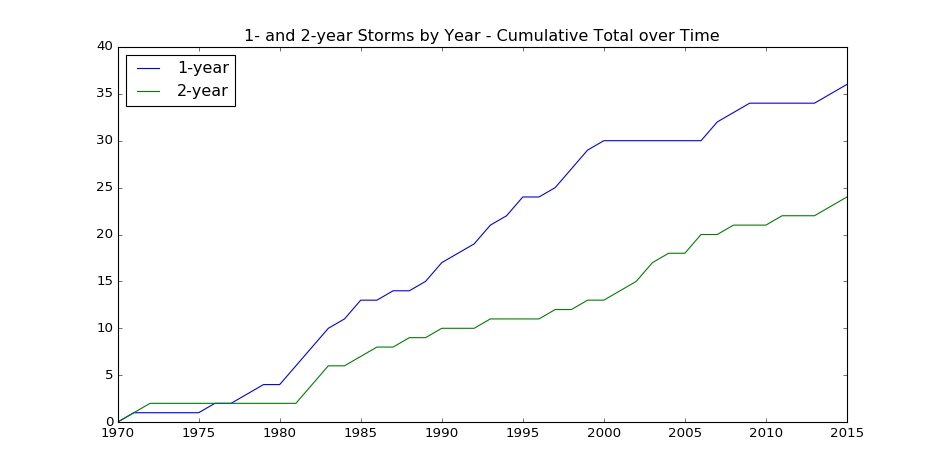

In [29]:
# Number of 1 and 2 year events per year
small_events.cumsum().plot(kind='line', stacked=False, title="1- and 2-year Storms by Year - Cumulative Total over Time")

#### From the graph above, it actually looks like the middle of the dataset has the most action.

#### Let's try something else.  Dividing the timeframes into buckets, and seeing if that helps get a big picture

In [89]:
# Divide into buckets using resampling
n_year_storms.resample('15A',how={'year':'count'})

d:\data_science_projects\chicagorain\virtualenvs\nyear-venv\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  from ipykernel import kernelapp as app


,year
start_time,
1971-12-31,2
1986-12-31,23
2001-12-31,33
2016-12-31,25


In [81]:
# Using the resample method is not really want giving me what I want.  Do this brute force
# TODO: Play around with resample to do this more efficiently

In [129]:
# I'd like to try and be a little more explicit in how I'm breaking this up
def find_bucket(year):
    if year < 1986:
        return '1970-1985'
    elif year <= 2000:
        return '1986-2000'
    else:
        return '2001-2015'
ns_by_year['year'] = ns_by_year.index.values
ns_by_year['bucket3'] = ns_by_year['year'].apply(find_bucket)
ns_by_year = ns_by_year.drop('year', 1)
ns_by_year.head()

,1-year,2-year,5-year,10-year,25-year,50-year,100-year,bucket3-year,bucket3
1970,0,0,0,0,0,0,0,1970-1985,1970-1985
1971,1,1,0,0,0,0,0,1970-1985,1970-1985
1972,0,1,0,0,0,0,0,1970-1985,1970-1985
1973,0,0,0,0,0,0,0,1970-1985,1970-1985
1974,0,0,0,0,0,0,0,1970-1985,1970-1985


In [131]:
bucket3 = ns_by_year.groupby('bucket3').sum()
bucket3.head()

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
bucket3,,,,,,,
1970-1985,13,7,2,2,0,0,0
1986-2000,17,6,3,2,1,0,1
2001-2015,6,11,6,1,1,2,2


In [133]:
# Make sure there are 83 storms
bucket3.sum().sum().sum()

83

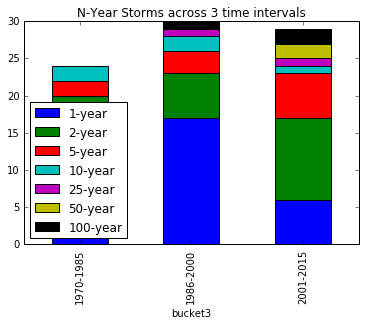

In [134]:
bucket3.plot(kind='bar', stacked=True, title="N-Year Storms across 3 time intervals")

#### A few thoughts.
* The middle interval has the most events
* 66% of the 100-year events and 100% of the 50-year events happened in the most recent interval
* The number of 2- and 5-year storms are going up
* The number of 1- and 10-year storms are going down

#### Let's break this into smaller intervals

In [136]:
ns_by_year.head()

,1-year,2-year,5-year,10-year,25-year,50-year,100-year,bucket3
1970,0,0,0,0,0,0,0,1970-1985
1971,1,1,0,0,0,0,0,1970-1985
1972,0,1,0,0,0,0,0,1970-1985
1973,0,0,0,0,0,0,0,1970-1985
1974,0,0,0,0,0,0,0,1970-1985


In [137]:
def find_bucket(year):
    if year < 1976:
        return "1970-1975"
    elif year < 1981:
        return '1976-1980'
    elif year < 1986:
        return '1981-1985'
    elif year < 1991:
        return '1986-1990'
    elif year < 1996:
        return '1991-1995'
    elif year < 2001:
        return '1996-2000'
    elif year < 2006:
        return '2001-2005'
    elif year < 2011:
        return '2006-2010'
    else:
        return '2011-2015'
ns_by_year['year'] = ns_by_year.index.values
ns_by_year['bucket8'] = ns_by_year['year'].apply(find_bucket)
ns_by_year = ns_by_year.drop('year', 1)
ns_by_year.head()

,1-year,2-year,5-year,10-year,25-year,50-year,100-year,bucket3,bucket8
1970,0,0,0,0,0,0,0,1970-1985,1970-1975
1971,1,1,0,0,0,0,0,1970-1985,1970-1975
1972,0,1,0,0,0,0,0,1970-1985,1970-1975
1973,0,0,0,0,0,0,0,1970-1985,1970-1975
1974,0,0,0,0,0,0,0,1970-1985,1970-1975


In [138]:
bucket8 = ns_by_year.drop('bucket3',1).groupby('bucket8').sum()
bucket8.head()

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
bucket8,,,,,,,
1970-1975,1,2,1,0,0,0,0
1976-1980,3,0,1,1,0,0,0
1981-1985,9,5,0,1,0,0,0
1986-1990,4,3,2,2,0,0,1
1991-1995,7,1,1,0,0,0,0


In [139]:
bucket8.sum().sum().sum()

83

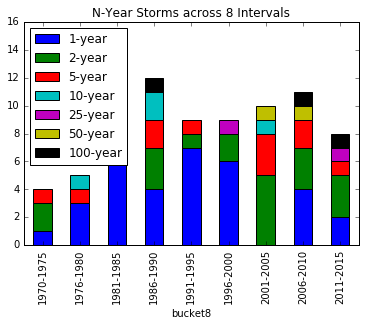

In [140]:
bucket8.plot(kind='bar', stacked=True, title="N-Year Storms across 8 Intervals")